In [75]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, BatchNormalization

tf.__version__

'2.0.0'

In [64]:
# hyperparameter 
lr = 1e-4
decay = 1e-2
batch_size = 50
epochs = 100

val_set_size_percentage = 10
test_set_size_percentage = 10

In [26]:
df = pd.read_csv('downjone5y.csv')

In [27]:

df = df.drop('Adj Close', axis=1)
df

,Date,Open,High,Low,Close,Volume
0,2014-10-31,17208.779297,17395.539063,17208.779297,17390.519531,121610000
1,2014-11-03,17390.900391,17410.650391,17339.849609,17366.240234,80030000
2,2014-11-04,17368.810547,17397.230469,17278.359375,17383.839844,81390000
3,2014-11-05,17385.759766,17486.589844,17385.759766,17484.529297,76030000
4,2014-11-06,17491.660156,17560.310547,17440.349609,17554.470703,70670000
5,2014-11-07,17558.580078,17575.330078,17493.369141,17573.929688,82860000
6,2014-11-10,17568.980469,17621.869141,17547.509766,17613.740234,71430000
7,2014-11-11,17615.640625,17638.210938,17584.939453,17614.900391,52880000
8,2014-11-12,17604.750000,17626.710938,17536.169922,17612.199219,75980000
9,2014-11-13,17618.689453,17705.480469,17583.880859,17652.789063,80540000


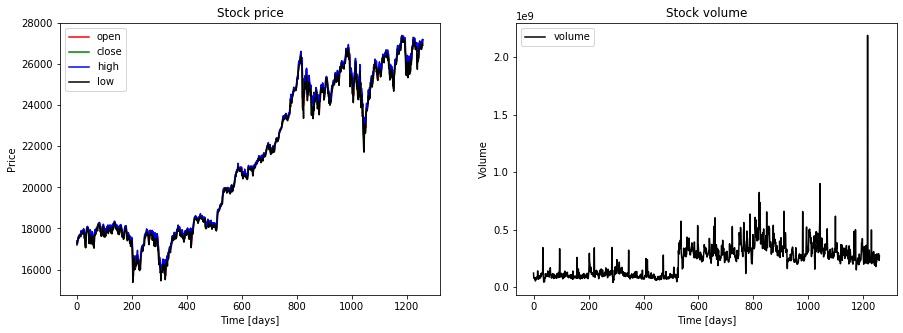

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df['Open'], color='red', label='open')
plt.plot(df['Close'], color='green', label='close')
plt.plot(df['High'], color='blue', label='high')
plt.plot(df['Low'], color='black', label='low')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [29]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))    
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [30]:
df_index = df.drop('Volume', axis=1)
df_index = df_index.drop('Date', axis=1)

cols = list(df_index.columns.values)
print('Col : ', cols)

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data
seq_len = 20
x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (991, 19, 4)
y_train.shape =  (991, 4)
x_val.shape =  (124, 19, 4)
y_val.shape =  (124, 4)
x_test.shape =  (124, 19, 4)
y_test.shape =  (124, 4)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


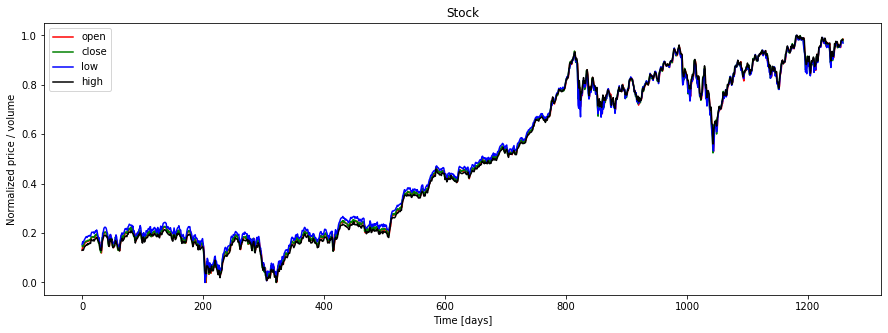

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(df_index_norm['Open'], color='red', label='open')
plt.plot(df_index_norm['Close'], color='green', label='close')
plt.plot(df_index_norm['Low'], color='blue', label='low')
plt.plot(df_index_norm['High'], color='black', label='high')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [ ]:
n_steps = seq_len - 1

# input_feed = Input(shape=(19, 4))
# x = LSTM(200, return_sequences=True)(x)
# prediction = Dense(4)(x)

# model = Model(inputs=input_feed, outputs=prediction)

model = Sequential([
    Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(19, 4)),
    TimeDistributed(BatchNormalization()),
    LSTM(100, activation='relu', dropout=0.5),
    Dense(4)
])

model.compile(optimizer=Adam(lr=lr, decay=decay),
             loss='mse', metrics=['mse'])

model.summary()
model.fit(x_train, y_train, epochs=epochs, verbose=1,
         batch_size=batch_size, validation_data=(x_val, y_val))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 19, 400)           328000    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 400)           1600      
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               200400    
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 404       
Total params: 530,404
Trainable params: 529,604
Non-trainable params: 800
_________________________________________________________________
Train on 991 samples, validate on 124 samples
Epoch 1/100
991/991 [==============================] - 9s 9ms/sample - loss: 0.4307 - mse: 0.4307 - val_loss: 0.6263 - val_mse: 0.6263
Epoch 2/100
991/991 [==============================] - 3s 3ms/

991/991 [==============================] - 3s 3ms/sample - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 55/100
991/991 [==============================] - 3s 3ms/sample - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 56/100
991/991 [==============================] - 3s 3ms/sample - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 57/100
991/991 [==============================] - 3s 3ms/sample - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 58/100
991/991 [==============================] - 3s 3ms/sample - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 59/100
991/991 [==============================] - 3s 3ms/sample - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 60/100
991/991 [==============================] - 3s 3ms/sample - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 61/100
991/991 [==============================] - 4s 4m

In [ ]:
x_train.shape
y_train.shape

In [ ]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [ ]:
ft = 0
 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
         color='gray', label='val target')
plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
        y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
        color='red', label='train prediction') 
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
        y_val_pred[:, ft], color='orange', label='val prediction')
plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
        y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
        y_test_pred[:, ft], color ='green', label='test prediction')
plt.title('past and future stock price')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
        y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
        y_test_pred[:, ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')

